In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# set traditional Chinese display
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

In [94]:
# Load datasets
data = pd.read_csv('../dataset/doubles 2/doubles/convert_shot.csv', encoding='utf-8')
rally_data = pd.read_csv('../dataset/doubles 2/doubles/rally.csv', encoding='utf-8')
set_data = pd.read_csv('../dataset/doubles 2/doubles/set.csv', encoding='utf-8')
match_data = pd.read_csv('../dataset/doubles 2/doubles/match.csv', encoding='utf-8')

# Merge rally_data with set_data to include match_id
rally_set_merged = rally_data.merge(set_data[['set_id', 'match_id']], on='set_id', how='left')

# Merge rally_set_merged with match_data to include player info
rally_set_match_merged = rally_set_merged.merge(match_data[['match_id', 'win_A', 'win_B', 'lose_C', 'lose_D']], on='match_id', how='left')

# Merge with the main convert_shot data
data_merged = data.merge(rally_set_match_merged[['rally_id', 'win_A', 'win_B', 'lose_C', 'lose_D']], on='rally_id', how='left')

# Initialize columns for hit_player and partner positions
data_merged['hit_player_x'] = None
data_merged['hit_player_y'] = None
data_merged['partner_x'] = None
data_merged['partner_y'] = None

# Function to assign hit_player and partner coordinates based on player info
def assign_player_positions(row):
    if row['player'] == row['win_A']:
        row['hit_player_x'] = row['player_A_x']
        row['hit_player_y'] = row['player_A_y']
        row['partner_x'] = row['player_B_x']
        row['partner_y'] = row['player_B_y']
    elif row['player'] == row['win_B']:
        row['hit_player_x'] = row['player_B_x']
        row['hit_player_y'] = row['player_B_y']
        row['partner_x'] = row['player_A_x']
        row['partner_y'] = row['player_A_y']
    elif row['player'] == row['lose_C']:
        row['hit_player_x'] = row['player_C_x']
        row['hit_player_y'] = row['player_C_y']
        row['partner_x'] = row['player_D_x']
        row['partner_y'] = row['player_D_y']
    elif row['player'] == row['lose_D']:
        row['hit_player_x'] = row['player_D_x']
        row['hit_player_y'] = row['player_D_y']
        row['partner_x'] = row['player_C_x']
        row['partner_y'] = row['player_C_y']
    if row['hit_player_y'] < 67:
        row['hit_player_y'] = 134 - row['hit_player_y']
        row['hit_player_x'] = 61 - row['hit_player_x']
        row['partner_x'] = 61 - row['partner_x']
        row['partner_y'] = 134 - row['partner_y']
    return row

# Apply the function to each row
data_merged = data_merged.apply(assign_player_positions, axis=1)
data_merged.drop(['start_frame_num','end_frame_num','time','return_height'], axis=1, inplace=True)
# Save the updated data
data_merged.to_csv('../output/Week11/updated_convert_shot.csv', index=False, encoding='utf-8')

# Check the result
print(data_merged.head())


   shot_id  rally_id  shot_num  player ball_type  backhand  player_A_x  \
0        1         1         1       5       發短球         1   28.639847   
1        2         1         2       7       推撲球         1   34.001378   
2        3         1         3       6        挑球         1   36.690095   
3        4         1         4       8        殺球         0   24.759652   
4        5         1         5       6        平球         1   24.160234   

   player_A_y  player_B_x  player_B_y  ...  hit_height  flaw  win_A  win_B  \
0   94.300792   31.751217  113.677100  ...           2     0      5      6   
1   88.407620   32.780770  114.213560  ...           2     0      5      6   
2   87.092290   36.825915  111.609023  ...           2     0      5      6   
3  109.455966   48.761037  122.480082  ...           1     0      5      6   
4  111.525887   46.772711  118.061801  ...           2     0      5      6   

   lose_C  lose_D  hit_player_x  hit_player_y  partner_x   partner_y  
0       7      

In [106]:
def assign_player_positions(row, prev_hit_player, current_hit_player):
    hit = prev_hit_player[0]
    partner = prev_hit_player[1]
    c_hit = current_hit_player[0]
    c_partner = current_hit_player[1]
    return row[f'player_{c_hit}_x'], row[f'player_{c_hit}_y'], row[f'player_{c_partner}_x'], row[f'player_{c_partner}_y'], row[f'player_{hit}_x'], row[f'player_{hit}_y'], row[f'player_{partner}_x'], row[f'player_{partner}_y']


In [107]:
def player(row):
    if row['player'] == row['win_A']:
        return ["A", "B"]
    elif row['player'] == row['win_B']:
        return ["B", "A"]
    elif row['player'] == row['lose_C']:
        return ["C", "D"]
    elif row['player'] == row['lose_D']:
        return ["D", "C"]
    else:
        return None

In [143]:
# Load the datasets
# convert_shot.csv: The result after running transform.py
data = pd.read_csv('../output/Week11/updated_convert_shot.csv', encoding='utf-8')
rally_data = pd.read_csv('../dataset/doubles 2/doubles/rally.csv', encoding='utf-8')
set_data = pd.read_csv('../dataset/doubles 2/doubles/set.csv', encoding='utf-8')

# Filter players
players_filtered = data

# Get the maximum shot number for each rally
max_shots_per_rally = players_filtered.groupby('rally_id')['shot_num'].max().reset_index()
max_shots_per_rally.columns = ['rally_id', 'max_shot_num']

# Merge the max_shots_per_rally back to the players_filtered
players_filtered = players_filtered.merge(max_shots_per_rally, on='rally_id', how='left')

# Merge rally_data with set_data to include set_win information
rally_set_merged = rally_data.merge(set_data[['set_id', 'set_win']], on='set_id', how='left')

# Initialize the list to collect rows
hit = []
opponent = []


# Initialize previous shot and position variables
prev_hit_player = None

# Iterate over the filtered DataFrame rows
for idx, row in players_filtered.iterrows():
    if row['shot_num'] == 1 or row['max_shot_num'] <= 3:
        # Update previous shot position for the first valid shot
        prev_hit_player = player(row)
        continue
    
    hit_player_x, hit_player_y, partner_x, partner_y, oppo_hit_x, oppo_hit_y, oppo_partner_x, oppo_partner_y = assign_player_positions(row, prev_hit_player, player(row))
    
    # Prepare the new row
    newrow_hit = {
        "shot_id": row["shot_id"],
        "hit_player_x": hit_player_x,
        "hit_player_y": hit_player_y,
        "partner_x": partner_x,
        "partner_y": partner_y,
        "score": 0, 
        "score_by_error": 0
    }
    newrow_opponent = {
        "shot_id": row["shot_id"],
        "hit_player_x": oppo_hit_x,
        "hit_player_y": oppo_hit_y,
        "partner_x": oppo_partner_x,
        "partner_y": oppo_partner_y,
        "score": 0,
        "score_by_error": 0
    }

    # Adjust for upper court if necessary
    if newrow_hit["hit_player_y"] > 67:
        newrow_hit["hit_player_x"] = 61 - newrow_hit["hit_player_x"]
        newrow_hit["hit_player_y"] = 134 - newrow_hit["hit_player_y"]
        newrow_hit["partner_x"] = 61 - newrow_hit["partner_x"]
        newrow_hit["partner_y"] = 134 - newrow_hit["partner_y"]
        
    if newrow_opponent["hit_player_y"] > 67:
        newrow_opponent["hit_player_x"] = 61 - newrow_opponent["hit_player_x"]
        newrow_opponent["hit_player_y"] = 134 - newrow_opponent["hit_player_y"]
        newrow_opponent["partner_x"] = 61 - newrow_opponent["partner_x"]
        newrow_opponent["partner_y"] = 134 - newrow_opponent["partner_y"]

    # Check if the current shot is one of the last two shots in the rally
    if row['shot_num'] >= row['max_shot_num'] - 1:
        rally_info = rally_set_merged[rally_set_merged['rally_id'] == row['rally_id']].iloc[0]
        set_win = rally_info['set_win']
        score_team = rally_info['score_team']
        if score_team == "NULL":
            continue
            
        if "對手" in str(rally_info['score_reason']):
            newrow_hit["score_by_error"] = 1
            newrow_opponent["score_by_error"] = 1

        # Determine which team won the point
        if row['shot_num'] == row['max_shot_num']:
            if ("對手" not in str(rally_info['score_reason'])):
                newrow_hit["score"] = 1
                newrow_opponent["score"] = -1
            else:
                newrow_hit["score"] = -1
                newrow_opponent["score"] = 1
            hit.append(newrow_hit)
            opponent.append(newrow_opponent)
        else:
            if ("對手" not in str(rally_info['score_reason'])):
                newrow_hit["score"] = -1
                newrow_opponent["score"] = 1
            else:
                newrow_hit["score"] = 1
                newrow_opponent["score"] = -1
            hit.append(newrow_hit)
            opponent.append(newrow_opponent)
        

    # Update previous shot and position after each shot for the next iteration
    prev_hit_player = player(row)

# Create DataFrames for win and lose shots
last_hit_df = pd.DataFrame(hit)
last_opponent_df = pd.DataFrame(opponent)

print("size of hit_df: ", last_hit_df.shape[0])
print("size of opponent_df: ", last_opponent_df.shape[0])

# Save to CSV
last_hit_df.to_csv('../output/Week11/last_hit.csv', index=False, encoding='utf-8')
last_opponent_df.to_csv('../output/Week11/last_oppo.csv', index=False, encoding='utf-8')


size of hit_df:  3688
size of opponent_df:  3688


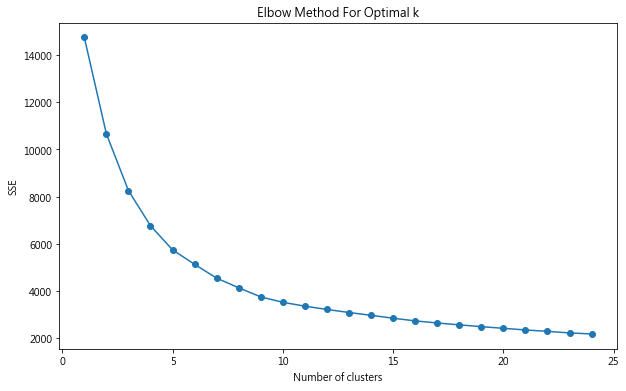

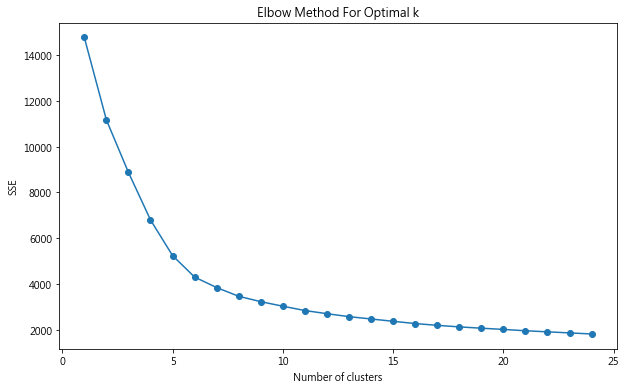

In [144]:
for name in ['hit', 'opponent']:
    data = last_hit_df if name == 'hit' else last_opponent_df
    # select features
    features = data[["hit_player_x", "hit_player_y", "partner_x", "partner_y"]]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # use elbow method to find the optimal k
    sse = []
    for k in range(1, 25):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        sse.append(kmeans.inertia_)

    # plot the elbow method
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 25), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method For Optimal k')
    plt.savefig(f'../output/Week11/elbow_plot_{name}.png')
    plt.show()

In [145]:
dataset_name = ['hit', 'opponent']

# clustering
n_hit = 9  # Best n from elbow method
kmeans_hit = KMeans(n_clusters=n_hit)
last_hit_df['cluster'] = kmeans_hit.fit_predict(last_hit_df[["hit_player_x", "hit_player_y", "partner_x", "partner_y"]])

n_opponent = 8
kmeans_opponent = KMeans(n_clusters=n_opponent)
last_opponent_df['cluster'] = kmeans_opponent.fit_predict(last_opponent_df[["hit_player_x", "hit_player_y", "partner_x", "partner_y"]])


In [146]:
# plot the clustering result
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# data_indices = data.index

for name in dataset_name:
    n = n_hit if name == 'hit' else n_opponent
    data = last_hit_df if name == 'hit' else last_opponent_df
    for cluster in range(0, n):
        plt.figure(figsize=(9.15, 10.05))
    
        cluster_data = data[data['cluster'] == cluster]
        if len(cluster_data) > 60:
            sample_cluster_data = cluster_data.sample(n=60, random_state=1)
        else:
            sample_cluster_data = cluster_data
    
        plt.scatter(sample_cluster_data['hit_player_x'], sample_cluster_data['hit_player_y'], color='r', label=f'Cluster {cluster} - Hit player')
        plt.plot([sample_cluster_data['hit_player_x'], sample_cluster_data['partner_x']], [sample_cluster_data['hit_player_y'], 
            sample_cluster_data['partner_y']], color='y', label=f'Cluster {cluster} - Partner line') 
        plt.scatter(sample_cluster_data['partner_x'], sample_cluster_data['partner_y'], color='b', label=f'Cluster {cluster} - Partner')
        plt.plot([sample_cluster_data['hit_player_x'].mean(), sample_cluster_data['partner_x'].mean()], [sample_cluster_data['hit_player_y'].mean(), 
            sample_cluster_data['partner_y'].mean()], color='g', label=f'Cluster {cluster} - Mean line', linewidth=5)
    
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.xlim(0, 61) 
        plt.ylim(0, 67)
        plt.savefig(f'../output/Week11/{name}_cluster_{cluster}_positions.jpg')
        plt.close()


In [147]:
last_hit_df.to_csv('../output/Week11/last_hit.csv', index=False, encoding='utf-8')
last_opponent_df.to_csv('../output/Week11/last_oppo.csv', index=False, encoding='utf-8')

In [148]:
filter_last_hit_df = last_hit_df[last_hit_df['score_by_error'] == 0]
filter_last_opponent_df = last_opponent_df[last_opponent_df['score_by_error'] == 0]
win_position = []
lose_position = []
for idx in range(0, filter_last_hit_df.shape[0], 2):
    newrow_win = {
        'position': None,
        'shot_id': filter_last_hit_df.iloc[idx+1]['shot_id']
    }
    newrow_lose = {
        'position': None,
        'shot_id': int(filter_last_hit_df.iloc[idx+1]['shot_id'])
    }
    if filter_last_hit_df.iloc[idx]['score'] == 1:
        win = 'hit'+str(int(filter_last_hit_df.iloc[idx]['cluster']))+'_opponent'+str(int(filter_last_opponent_df.iloc[idx+1]['cluster']))
        lose = 'opponent'+str(int(filter_last_opponent_df.iloc[idx]['cluster']))+'_hit'+str(int(filter_last_hit_df.iloc[idx+1]['cluster']))
    else:
        win = 'opponent'+str(int(filter_last_opponent_df.iloc[idx]['cluster']))+'_hit'+str(int(filter_last_hit_df.iloc[idx+1]['cluster']))
        lose = 'hit'+str(int(filter_last_hit_df.iloc[idx]['cluster']))+'_opponent'+str(int(filter_last_opponent_df.iloc[idx+1]['cluster']))
    newrow_win['position'] = win
    win_position.append(newrow_win)
    newrow_lose['position'] = lose
    lose_position.append(newrow_lose)
win_position_df = pd.DataFrame(win_position)
lose_position_df = pd.DataFrame(lose_position)

win_position_df.to_csv('../output/Week11/win_position.csv', index=False, encoding='utf-8')
lose_position_df.to_csv('../output/Week11/lose_position.csv', index=False, encoding='utf-8')
        

In [149]:
pd.set_option('display.max_rows', None)

print(win_position_df.shape[0])
print(win_position_df['position'].value_counts())
print(lose_position_df.shape[0])
print(lose_position_df['position'].value_counts())

576
opponent2_hit1    49
opponent0_hit1    38
opponent4_hit3    32
opponent5_hit6    28
opponent5_hit1    22
opponent2_hit7    21
opponent6_hit2    21
opponent6_hit5    21
opponent5_hit3    19
opponent5_hit7    19
opponent0_hit8    17
opponent1_hit4    16
opponent6_hit4    15
opponent1_hit6    14
opponent6_hit6    14
opponent7_hit7    12
opponent2_hit2    11
opponent2_hit6    11
opponent1_hit5    11
opponent2_hit8    11
opponent4_hit0    10
opponent7_hit3    10
opponent7_hit1    10
opponent6_hit1    10
opponent5_hit0    10
opponent7_hit0     9
opponent7_hit8     8
opponent0_hit0     7
opponent6_hit8     6
opponent1_hit2     6
opponent5_hit8     6
opponent4_hit1     6
opponent5_hit2     5
opponent7_hit4     5
opponent7_hit6     5
opponent4_hit8     5
opponent0_hit5     4
opponent2_hit3     4
opponent0_hit4     4
opponent0_hit7     4
opponent6_hit0     4
opponent0_hit3     4
opponent1_hit8     4
opponent1_hit1     4
opponent1_hit0     3
opponent7_hit2     3
opponent1_hit3     3
opponent0